GPU-accelerated demo using nx-cugraph
-------------------------------------
In this demo we replicate the HyperNetX results in the [HIF case study](https://github.com/pszufe/HIF-standard/blob/main/tutorials/HIF-demo.ipynb) and calculate the 1-closeness centrality in the publications dataset. We implement this algorithm over the incidence graph with the [`nx.shortest_path_length`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path_length.html#networkx.algorithms.shortest_paths.generic.shortest_path_length) function in the cugraph GPU-accelerated backend for NetworkX.

## Setting up CUDA
We set up the nx-cugraph environment using [RAPIDS install](https://docs.rapids.ai/install/#selector) with Conda instead of [CUDA install](https://developer.nvidia.com/cuda-downloads). This [NetworkX backend](https://networkx.org/documentation/stable/reference/backends.html) will transparently dispatch many functions to the GPU including:
* [`nx.forceatlas2_layout`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html#networkx.algorithms.components.connected_components)
* [`nx.connected_components`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.forceatlas2_layout.html#networkx.drawing.layout.forceatlas2_layout)

## Conclusions
Using nx-cugraph to accelerate higher-order network analysis seems promising. Basic centrality algorithms can be implemented in a few lines of Python with transparent GPU dispatching. Performance results are mixed, which is explained by the size of the incidence graph. [Benchmarks](https://docs.rapids.ai/api/cugraph/stable/nx_cugraph/benchmarks/#datasets) show that small datasets such as this one have suboptimal results. The demo shows a significant speed-up in the ForceAtlas2 drawing algorithm but not on `nx.shortest_path_length`. Other GPU algorithms like [`nx.betweenness_centrality`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality) show slowdowns with respect to their CPU counterparts for this particular incidence graph.

We hope that future versions will improve performance for small graphs, and case studies will also reflect on GPU support.

In [1]:
%env NX_CUGRAPH_AUTOCONFIG=True

import networkx as nx
nx.config.warnings_to_ignore.add("cache")

from src.nx_hif import *
from src.nx_hif.hif import *
from src.nx_hif.readwrite import *

env: NX_CUGRAPH_AUTOCONFIG=True


In [2]:
V, E, I = read_hif("data/publications.hif.json")

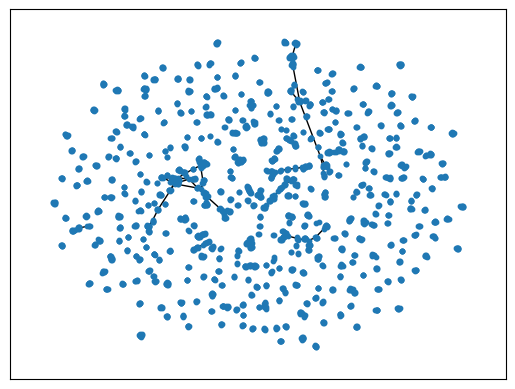

In [3]:
pos = nx.forceatlas2_layout(I)
nx.draw_networkx(I, pos=pos, with_labels=False, node_size=10)

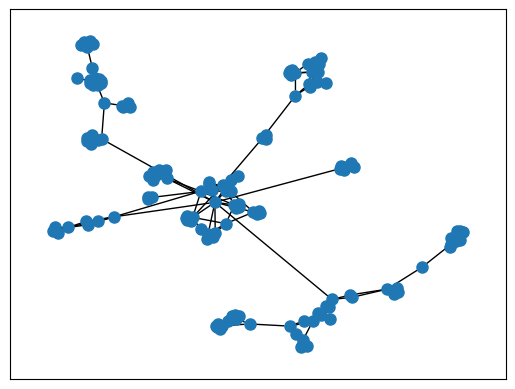

In [11]:
largest_component = max(nx.connected_components(I), key=len)
largest_subgraph = I.subgraph(largest_component).copy()
pos2 = nx.forceatlas2_layout(largest_subgraph)
nx.draw_networkx(largest_subgraph, pos=pos2, with_labels=False, node_size=64)

In [12]:
hif_s_closeness_centrality((V, E, largest_subgraph), 1)

{'A Survey on Hypergraph Representation Learning': 0.3855421686746988,
 'Spatial-temporal hypergraph based on dual-stage attention network for multi-view data lightweight action recognition': 0.36363636363636365,
 'Penalized Flow Hypergraph Local Clustering': 0.5079365079365079,
 'LightHGNN: Distilling Hypergraph Neural Networks into MLPs for 100-times Faster Inference': 0.5614035087719298,
 'Multimodal Fusion via Hypergraph Autoencoder and Contrastive Learning for Emotion Recognition in Conversation': 0.2601626016260163,
 'Divide-Aggregate Heterogeneous Hypergraph for large-scale user intention detection': 0.35555555555555557,
 'Hypergraph based Understanding for Document Semantic Entity Recognition': 0.26666666666666666,
 'Hypergraph motifs and their extensions beyond binary': 0.3855421686746988,
 'LightHGNN: Distilling Hypergraph Neural Networks into MLPs for 100x Faster Inference': 0.5614035087719298,
 'Hypergraph Dynamic System': 0.5614035087719298,
 'HyperSMOTE: A Hypergraph-base